<a href="https://colab.research.google.com/github/chminPark/ml-python/blob/master/%EC%8B%A4%EC%8A%B5_PretrainedModel%ED%99%9C%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Pytorch로 개발하기 위한 Library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

import numpy as np

torch.__version__

'2.1.0+cu118'

In [ ]:
!gdown --id 1nOUWByW6ifnd_P-Jgd4mbNkAT-jGzpWC
!mkdir 'semicon'
!unzip -q semiconductor_dataset.zip -d semicon
!rm semiconductor_dataset.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1nOUWByW6ifnd_P-Jgd4mbNkAT-jGzpWC
To: /content/semiconductor_dataset.zip
100% 10.3M/10.3M [00:00<00:00, 257MB/s]
mkdir: cannot create directory ‘semicon’: File exists
replace semicon/abnorm_1/1-4.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import csv
import os
import pandas as pd
"""
Args:
  directory_string: 이미지가 저장되어 있는 폴더 Path
  output_csv_name: csv 파일 이름
Returns:
  csv file
"""
def build_csv(directory_string, output_csv_name):

    directory = directory_string
    class_list = os.listdir(directory)
    class_list.sort()


    with open(output_csv_name, 'w', newline='') as csvfile:

        ### 실습 : CSV 파일 Object 생성
        writer = csv.writer(csvfile, delimiter=',')
        ############################################
        writer.writerow(['file_name', 'file_path', 'class_name', 'class_index']) # CSV의 column 이름을 지정

        ###### 각 folder에 들어가서 각 이미지의 이름을 가져옴
        for class_name in class_list:
          class_path = os.path.join(directory, class_name)
          file_list = os.listdir(class_path) # 해당 파일 내부의 이미지를 확보
          for file_name in file_list:
              file_path = os.path.join(directory, class_name, file_name) #concatenate class folder dir, class name and file name
              writer.writerow([file_name, file_path, class_name, class_name.split("_")[1]]) #write the file path and class name to the csv file
        #############################

    return

train_folder = os.path.join(os.getcwd(), 'semicon')
build_csv(train_folder, 'train.csv')
train_df = pd.read_csv('train.csv')


In [ ]:
train_df

,file_name,file_path,class_name,class_index
0,1-97.jpg,/content/semicon/abnorm_1/1-97.jpg,abnorm_1,1
1,1-4.jpg,/content/semicon/abnorm_1/1-4.jpg,abnorm_1,1
2,2-6.jpg,/content/semicon/abnorm_1/2-6.jpg,abnorm_1,1
3,2-10.jpg,/content/semicon/abnorm_1/2-10.jpg,abnorm_1,1
4,1-99.jpg,/content/semicon/abnorm_1/1-99.jpg,abnorm_1,1
...,...,...,...,...
193,2-68.jpg,/content/semicon/normal_0/2-68.jpg,normal_0,0
194,2-37.jpg,/content/semicon/normal_0/2-37.jpg,normal_0,0
195,1-69.jpg,/content/semicon/normal_0/1-69.jpg,normal_0,0
196,2-36.jpg,/content/semicon/normal_0/2-36.jpg,normal_0,0


# Custom데이터를 활용하기 위한 Dataset을 선언
- pytorch의 `dataloader`를 이용하기 위해서는 `torch.utils.data.Dataset` 클래스를 상속한 클래스의 선언이 필요하다.
- 클래스 내에 `__init__`, `__getitem__`, `__len__`의 3개의 메소드를 선언하여 오버라이드한다.

In [ ]:
import cv2
import torch
from torch.utils.data import Dataset

class semiconductorDataset(Dataset): # inheritin from Dataset class

    def __init__(self, csv_file, root_dir="", transform=None):
        self.annotation_df = pd.read_csv(csv_file)
        self.root_dir = root_dir # root directory of images, leave "" if using the image path column in the __getitem__ method
        self.transform = transform

    def __len__(self):
        return len(self.annotation_df) # return length (numer of rows) of the dataframe

    ############ 실습 : annotation_df에 있는 이미지를 읽어 들어서, 변경한후
    ############        읽어 들인 값을 return 하는 함수를 작성한다.
    def __getitem__(self, idx):

        ##### Image 읽기
        image_path = os.path.join(self.root_dir, self.annotation_df.iloc[idx, 1]) #use image path column (index = 1) in csv file
        image = cv2.imread(image_path) # read image by cv2
        #### 이미지를 Channel순서를 변경
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert from BGR to RGB for matplotlib
        #### 이미지 Transform
        if self.transform:
            image = self.transform(image)

        #### 이미지에 대한 추가 정보 확인
        class_name = self.annotation_df.iloc[idx, 2] # use class name column (index = 2) in csv file
        class_index = self.annotation_df.iloc[idx, 3] # use class index column (index = 3) in csv file

        return image, class_name, class_index

In [ ]:
# https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import pandas as pd


transform = transforms.Compose([
    transforms.ToTensor(), # PIL Image를 Tensor로 변경
    transforms.Resize((100,100), antialias=True), # 크기 변경
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # Normalize
    # transforms.Grayscale(), # Gray Scale로 변경 /
    transforms.RandomAdjustSharpness(sharpness_factor=2), # randomly adjusts the sharpness
    transforms.RandomAutocontrast() # 임의로 Contrast변경
])

##### 실습 : train_dataset 선언
train_dataset = semiconductorDataset(csv_file='train.csv', root_dir="", transform=transform)

In [ ]:
# Image plotting function
def img_plt(X_train, Y_train, n):
  X_train_2d = X_train.reshape(X_train.shape[0], 256, 256)
  fig, axes = plt.subplots(n, 10, figsize=(10,10))
  for j in range(n):
    for i in range(10):
        ax = axes[j, i]
        try:
          ax.imshow(X_train_2d[Y_train==j][i], cmap='gray_r')
          ax.axis('off')
          if i == 0:
            ax.set_title('Cluster: {}'.format(j))
        except:
          ax.axis('off')

  plt.tight_layout()
  plt.show()

# Batch 단위 학습을 위한 DataLoader 선언
 - Dataset내부의 샘플들을 batch 크기로 추출
 - Batch Size는 1step에 들어간 데이터의 개수
 - Epoch 마다 데이터를 섞어(Shuffle) Overfitting을 방지
 - 병렬처리를 지원하여 데이터 검색 속도를 향상


In [ ]:
len(train_dataset)

198

In [ ]:
#### 실습 : torch.utils.DataLoader를 이용하여 데이터를 load. Batch 크기를 10으로 한다.
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=10, shuffle=True, num_workers=2)

for i, data in enumerate(train_dataloader):
  images, class_name, labels = data
  print(images.shape, labels.shape)

  # 5번만 데이터를 load하고 멈춘다
  if i > 3:
    break

torch.Size([10, 3, 100, 100]) torch.Size([10])
torch.Size([10, 3, 100, 100]) torch.Size([10])
torch.Size([10, 3, 100, 100]) torch.Size([10])
torch.Size([10, 3, 100, 100]) torch.Size([10])
torch.Size([10, 3, 100, 100]) torch.Size([10])


# VGG16를 Pretrained Model을 이용하여 학습한다.

<img src="https://editor.analyticsvidhya.com/uploads/51271vgg.jpeg" height="150px" width="800px">



In [ ]:
from torchvision import models
import torch

vgg16_pretrained = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

print(vgg16_pretrained)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# 최종 결과가 1000개로 나온다. 우리의 데이터는 11개의 class로 변경해야 한다.
vgg16_pretrained.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
vgg16_pretrained.classifier[3]

Linear(in_features=4096, out_features=4096, bias=True)

In [ ]:
# [참고] python에서 -1은 맨 뒤의 인자를 의미합니다.
a = [1,2,3,4,5]
a[-1], a[-2], a[:-1]

(5, 4, [1, 2, 3, 4])

In [ ]:
vgg16_pretrained.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
# 맨 뒤의 linear layer가 우리 데이터를 지원할 수 있도록 변경하고 싶다 = 11개
# 두번째 linear layer의 hidden feature 개수를 4096에서 1000 로 줄이고 싶다
vgg16_pretrained.classifier[3] = nn.Linear(in_features=4096, out_features=1000, bias=True)
vgg16_pretrained.classifier[6] = nn.Linear(in_features=1000, out_features=11)

In [ ]:
# 변경된 것을 확인할 수 있다
vgg16_pretrained.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=1000, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=1000, out_features=11, bias=True)
)

In [ ]:
def train(model, data_loader, criterion, optimizer, n_epoch):

  model.train() #
  for epoch in range(n_epoch):
    running_loss = 0
    ### 실습 : Custom dataloader 에서 값을 가져온다
    for i, (images, _, labels) in enumerate(data_loader):
      images, labels = images.cuda(), labels.cuda()
      outputs = model(images)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if (i + 1) % 100 == 0:
        print('iteration: [{}/{}]'.format(i + 1, len(data_loader)))

    print('Epoch {}, loss = {:.3f}'.format(epoch + 1, running_loss/len(data_loader)))

In [ ]:
def eval(model, data_loader):

  model.eval()
  total = 0
  correct = 0

  preds = []
  trues = []

  with torch.no_grad():
    ### 실습 : Custom dataloader 에서 값을 가져온다
    for images, _,  labels in data_loader:
      images, labels = images.cuda(), labels.cuda()
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      preds.append(predicted.detach().cpu().numpy())
      trues.append(labels.detach().cpu().numpy())

    accuracy = 100 * correct / total

  print('Test Accuracy: {}%'.format(accuracy))
  return preds, trues


In [ ]:
def reset_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
# 학습 전에는 ImageNet의 정보를 이용하여 성능이 좋지 않음
vgg16 = vgg16_pretrained.to("cuda")
preds, trues = eval(vgg16, train_dataloader)
prediction_label = np.stack(preds[0:-1]).flatten()
train_labels = np.stack(trues[0:-1]).flatten()

from sklearn.metrics import classification_report
print(classification_report(train_labels, prediction_label))

Test Accuracy: 12.121212121212121%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.00      0.00      0.00        16
           2       0.14      0.28      0.18        18
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00        17
           6       0.14      0.17      0.15        18
           7       0.14      0.89      0.24        18
           8       0.00      0.00      0.00        18
           9       0.00      0.00      0.00        17
          10       0.00      0.00      0.00        18

    accuracy                           0.13       190
   macro avg       0.04      0.12      0.05       190
weighted avg       0.04      0.13      0.05       190



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
reset_seed(2020)
criterion = nn.CrossEntropyLoss()

vgg16 = vgg16_pretrained.to("cuda")

# transfer learning을 할때에는 learning rate을 작은 값으로 수행합니다.
optimizer = optim.Adam(params=vgg16.parameters(), lr=0.00003)

train(vgg16, train_dataloader, criterion, optimizer, n_epoch=7)

Epoch 1, loss = 2.344
Epoch 2, loss = 1.538
Epoch 3, loss = 0.485
Epoch 4, loss = 0.152
Epoch 5, loss = 0.178
Epoch 6, loss = 0.154
Epoch 7, loss = 0.018


# 정확도를 평가해 봅시다
* 데이터가 너무 적어서 평가 데이터에 대한 정확도를 봅니다

In [ ]:
preds, trues = eval(vgg16, train_dataloader)

Test Accuracy: 100.0%


In [ ]:
prediction_label = np.stack(preds[0:-1]).flatten()
train_labels = np.stack(trues[0:-1]).flatten()

from sklearn.metrics import classification_report
print(classification_report(train_labels, prediction_label))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        16
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        18
           8       1.00      1.00      1.00        16
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        18

    accuracy                           1.00       190
   macro avg       1.00      1.00      1.00       190
weighted avg       1.00      1.00      1.00       190



In [ ]:
# 위의 학습 방식은 "Train the entire model" Transfer learning 방식입니다.
for name, param in vgg16.named_parameters():
  print(name, param.requires_grad)

features.0.weight True
features.0.bias True
features.2.weight True
features.2.bias True
features.5.weight True
features.5.bias True
features.7.weight True
features.7.bias True
features.10.weight True
features.10.bias True
features.12.weight True
features.12.bias True
features.14.weight True
features.14.bias True
features.17.weight True
features.17.bias True
features.19.weight True
features.19.bias True
features.21.weight True
features.21.bias True
features.24.weight True
features.24.bias True
features.26.weight True
features.26.bias True
features.28.weight True
features.28.bias True
classifier.0.weight True
classifier.0.bias True
classifier.3.weight True
classifier.3.bias True
classifier.6.weight True
classifier.6.bias True


# 맨 뒤에 Classifier만 학습하고 싶다.

In [ ]:
from torchvision import models
import torch

vgg16_pretrained = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

print(vgg16_pretrained)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for name, param in vgg16_pretrained.named_parameters():
  print(name, param.requires_grad)

features.0.weight True
features.0.bias True
features.2.weight True
features.2.bias True
features.5.weight True
features.5.bias True
features.7.weight True
features.7.bias True
features.10.weight True
features.10.bias True
features.12.weight True
features.12.bias True
features.14.weight True
features.14.bias True
features.17.weight True
features.17.bias True
features.19.weight True
features.19.bias True
features.21.weight True
features.21.bias True
features.24.weight True
features.24.bias True
features.26.weight True
features.26.bias True
features.28.weight True
features.28.bias True
classifier.0.weight True
classifier.0.bias True
classifier.3.weight True
classifier.3.bias True
classifier.6.weight True
classifier.6.bias True


In [ ]:
# 맨 뒤에 Classifier만 !!나머지는 Frozen
for name, param in vgg16_pretrained.named_parameters():
  if "classifier" in name:
    print(name, param.requires_grad)
  else:
    param.requires_grad = False

classifier.0.weight True
classifier.0.bias True
classifier.3.weight True
classifier.3.bias True
classifier.6.weight True
classifier.6.bias True


In [ ]:
## 확인
for name, param in vgg16_pretrained.named_parameters():
  print(name, param.requires_grad)

features.0.weight False
features.0.bias False
features.2.weight False
features.2.bias False
features.5.weight False
features.5.bias False
features.7.weight False
features.7.bias False
features.10.weight False
features.10.bias False
features.12.weight False
features.12.bias False
features.14.weight False
features.14.bias False
features.17.weight False
features.17.bias False
features.19.weight False
features.19.bias False
features.21.weight False
features.21.bias False
features.24.weight False
features.24.bias False
features.26.weight False
features.26.bias False
features.28.weight False
features.28.bias False
classifier.0.weight True
classifier.0.bias True
classifier.3.weight True
classifier.3.bias True
classifier.6.weight True
classifier.6.bias True


In [ ]:
# Freeze the convolutional base
reset_seed(2020)
criterion = nn.CrossEntropyLoss()

vgg16 = vgg16_pretrained.to("cuda")

# transfer learning을 할때에는 learning rate을 작은 값으로 수행합니다.
optimizer = optim.Adam(params=vgg16.parameters(), lr=0.00001)

train(vgg16, train_dataloader, criterion, optimizer, n_epoch=7)


Epoch 1, loss = 9.163
Epoch 2, loss = 5.604
Epoch 3, loss = 3.850
Epoch 4, loss = 2.772
Epoch 5, loss = 1.978
Epoch 6, loss = 1.512
Epoch 7, loss = 1.065


In [ ]:
preds, trues = eval(vgg16, train_dataloader)

prediction_label = np.stack(preds[0:-1]).flatten()
train_labels = np.stack(trues[0:-1]).flatten()

from sklearn.metrics import classification_report
print(classification_report(train_labels, prediction_label))

Test Accuracy: 96.96969696969697%
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        17
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        16
           4       1.00      1.00      1.00        17
           5       1.00      0.94      0.97        17
           6       0.94      1.00      0.97        17
           7       1.00      0.94      0.97        18
           8       0.88      0.94      0.91        16
           9       1.00      0.82      0.90        17
          10       1.00      1.00      1.00        18

    accuracy                           0.97       190
   macro avg       0.97      0.97      0.97       190
weighted avg       0.97      0.97      0.97       190



#Train some layers and leave others frozon

In [ ]:
# pretrained 모델 가져오기
from torchvision import models

vgg16_pretrained = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
vgg16_pretrained

In [ ]:
# 데이터셋에 맞에 변경하기
vgg16_pretrained.classifier[3] = nn.Linear(in_features=4096, out_features=1000, bias=True)
vgg16_pretrained.classifier[6] = nn.Linear(in_features=1000, out_features=11, bias=True)

In [ ]:
# 일부 layer frozon  하기
for name, params in vgg16_pretrained.named_parameters():
  # print(name, params.requires_grad)

  if 'features' in name:
    idx = int(name.split(".")[1])
    if idx <= 5:
      params.requires_grad = False

In [ ]:
for name, params in vgg16_pretrained.named_parameters():
  print(name, params.requires_grad)

In [ ]:
# 학습하기
reset_seed(2020)
criterion = nn.CrossEntropyLoss()

vgg16 = vgg16_pretrained.to("cuda")

# transfer learning을 할때에는 learning rate을 작은 값으로 수행합니다.
optimizer = optim.Adam(params=vgg16.parameters(), lr=0.00003)

train(vgg16, train_dataloader, criterion, optimizer, n_epoch=7)

Epoch 1, loss = 2.278
Epoch 2, loss = 1.340
Epoch 3, loss = 0.436
Epoch 4, loss = 0.167
Epoch 5, loss = 0.063
Epoch 6, loss = 0.091
Epoch 7, loss = 0.115


In [ ]:
# 평가
preds, trues = eval(vgg16, train_dataloader)

prediction_label = np.stack(preds[0:-1]).flatten()
train_labels = np.stack(trues[0:-1]).flatten()

from sklearn.metrics import classification_report
print(classification_report(train_labels, prediction_label))

Test Accuracy: 86.86868686868686%
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        17
           1       0.81      0.94      0.87        18
           2       1.00      1.00      1.00        19
           3       0.94      0.94      0.94        16
           4       1.00      1.00      1.00        17
           5       0.89      0.94      0.91        17
           6       0.85      1.00      0.92        17
           7       0.80      0.89      0.84        18
           8       0.79      0.69      0.73        16
           9       0.89      0.47      0.62        17
          10       1.00      1.00      1.00        18

    accuracy                           0.87       190
   macro avg       0.88      0.87      0.87       190
weighted avg       0.88      0.87      0.87       190



# Visualize 해보겠습니다

In [ ]:
prediction_label = np.stack(preds[0:-1]).flatten()
train_labels = np.stack(trues[0:-1]).flatten()

In [ ]:
idx_diff = np.where(train_labels != prediction_label)
labels_diff = train_labels[idx_diff]
predicted_diff = prediction_label[idx_diff]


for t, p in zip(labels_diff, predicted_diff):
  print(f"정답 Label은 {t}, 예측 Label은 {p}")


정답 Label은 0, 예측 Label은 6
정답 Label은 7, 예측 Label은 8
정답 Label은 9, 예측 Label은 0
정답 Label은 9, 예측 Label은 0
정답 Label은 0, 예측 Label은 3
정답 Label은 8, 예측 Label은 7
정답 Label은 9, 예측 Label은 8
정답 Label은 9, 예측 Label은 1
정답 Label은 5, 예측 Label은 0
정답 Label은 3, 예측 Label은 0
정답 Label은 0, 예측 Label은 5
정답 Label은 8, 예측 Label은 9
정답 Label은 8, 예측 Label은 6
정답 Label은 9, 예측 Label은 8
정답 Label은 8, 예측 Label은 0
정답 Label은 9, 예측 Label은 7
정답 Label은 9, 예측 Label은 7
정답 Label은 9, 예측 Label은 0
정답 Label은 1, 예측 Label은 5
정답 Label은 8, 예측 Label은 7
정답 Label은 0, 예측 Label은 1
정답 Label은 9, 예측 Label은 6
정답 Label은 0, 예측 Label은 1
정답 Label은 7, 예측 Label은 1


In [ ]:
## 실습 : 전체 데이터를 한번에 가져오고, 이 결과를 기반으로 Report출력
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=len(train_dataset),
                                               shuffle=False, num_workers=1)

labels, predicted,images, names = None, None, None, None
with torch.no_grad():
  for images, names,  labels in train_dataloader:
    continue

names = np.array(list(names))

print(images.shape, np.shape(names), labels.shape)


images = images.squeeze()
print(images.shape)

#images = images.view(images.shape[0], -1)
#images.shape

torch.Size([198, 3, 100, 100]) (198,) torch.Size([198])
torch.Size([198, 3, 100, 100])


RuntimeError: ignored

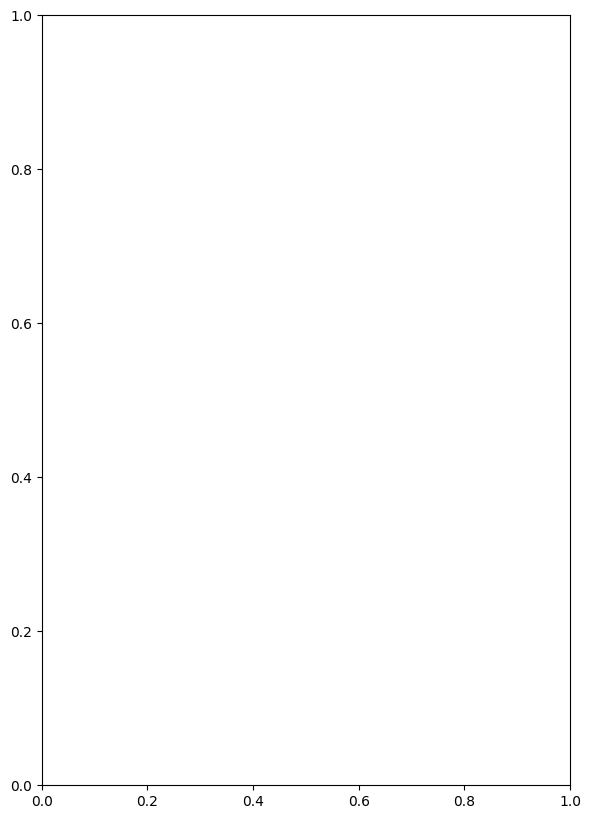

In [ ]:
### 실습 : label 이 0인 이미지 중 5개만 추려서 출력해 봅시다
target_index = np.where(labels == 0)[0]
random_idx = np.random.choice(target_index, 2)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_idx):

  plt.subplot(1, 2, i+1)
  plt.imshow(images[idx].reshape(256,256,3), cmap='gray_r')
  plt.title('Digit : {} '.format(names[idx]), fontsize=14)
  plt.xticks([]); plt.yticks([])
